In [1]:
%matplotlib inline
#%pylab
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mpc
import matplotlib.dates as dts
import numpy as np
import math
#import pandas as pd
import itertools
import os
#import ROOT
import datetime
#from root_numpy import root2array, root2rec, tree2rec, array2root
from scipy.optimize import curve_fit
from scipy.misc import factorial
plt.rcParams.update({'font.size': 16})

In [2]:
from decode import GetWaveforms
from decode import GetWaveformsNoiseRemoval

In [3]:
from datetime import datetime

In [21]:
# gas run 2
PATH = '/Users/davidc/Downloads/Gas_15psi/measures/'
# liquid run 2
#PATH = '/Users/davidc/Downloads/LiquidArgon/VC200_VCG130/measures/'
# liquid run 1
#PATH = '/Users/davidc/Downloads/RUN1/measures/'
#gas run 3
#PATH = '/Users/davidc/Downloads/RUN3/15psi/data/'
datafile_v = os.listdir(PATH)
print(datafile_v)
dt = 0.0005
datafile_v.sort()
print(datafile_v)
RC=0.240

['PrM1-2018_08_06-11_34_15.dat', 'PrM1-2018_08_06-11_35_46.dat', '.DS_Store', 'PrM1-2018_08_06-11_49_05.dat', 'PrM1-2018_08_06-11_44_22.dat', 'PrM1-2018_08_06-11_42_45.dat', 'PrM1-2018_08_06-11_40_58.dat', 'PrM1-2018_08_06-11_38_50.dat', 'PrM1-2018_08_06-11_46_00.dat', 'PrM1-2018_08_06-11_37_14.dat', 'PrM1-2018_08_06-11_47_35.dat']
['.DS_Store', 'PrM1-2018_08_06-11_34_15.dat', 'PrM1-2018_08_06-11_35_46.dat', 'PrM1-2018_08_06-11_37_14.dat', 'PrM1-2018_08_06-11_38_50.dat', 'PrM1-2018_08_06-11_40_58.dat', 'PrM1-2018_08_06-11_42_45.dat', 'PrM1-2018_08_06-11_44_22.dat', 'PrM1-2018_08_06-11_46_00.dat', 'PrM1-2018_08_06-11_47_35.dat', 'PrM1-2018_08_06-11_49_05.dat']


In [6]:
def gettime(name):
    date = name.split('PrM1-')[-1].split('.dat')[0]
    time = datetime.strptime(date,'%Y_%m_%d-%H_%M_%S')
    return time

In [7]:
def time_drift_anode(values_vector, time_vector):
        tol=0.005#0.0004 #per run 1 0.00034
        #per gas 0.005
        
        control_anode_max=0
        control_anode_min=0
        control_cathode_max=0
        control_cathode_min=0
        baseline_anode,baseline_cathode=det_baseline(values_vector,time_vector)
            
            #print(baseline_anode,baseline_cathode)
        max_anode=np.max(values_vector[0])
        print(max_anode)
        ind_max=values_vector[0].tolist().index(np.max(values_vector[0]))
        time_max_anode=time_vector[ind_max]#[values_vector[0].index(np.max(values_vector[0]))]
        ind_min=values_vector[1].tolist().index(np.min(values_vector[1]))
        
        #print(ind_max,ind_min)
        min_cathode=np.min(values_vector[1])
        time_min_cathode=time_vector[ind_min]#[values_vector[1].index(np.min(values_vector[1]))]
            #print (min_cathode, baseline_cathode)
        #print((max_anode-baseline_anode)/2.0,(min_cathode-baseline_cathode)/2.0, baseline_anode, baseline_cathode, max_anode, min_cathode)    
        for m in range(len(values_vector[0])):
           # print '\t current point : A : %.04f \t C : %0.4f'%(values_vector[0][m],values_vector[1][m])
            if control_anode_min==0:
                if values_vector[0][m]>=(((max_anode-baseline_anode)/4.0)+baseline_anode):
                
                    time_anode_1=time_vector[m]
                    quarter_values_anode=values_vector[0][m]
                    control_anode_min=1
                    #print("anodo 1/4")
                    #print(halfheight_values_anode, (max_anode-baseline_anode)/2.0)
            if control_anode_max==0:
                if values_vector[0][m]>=((3.0*(max_anode-baseline_anode)/4.0)+baseline_anode):
                
                    time_anode_2=time_vector[m]
                    threeQuarter_values_anode=values_vector[0][m]
                    control_anode_max=1    
                   # print("anodo 3/4")
            if control_cathode_min==0:
                    #print(values_vector[n][1][m],(min_cathode-baseline_cathode)/2 )
                if values_vector[1][m]<=(((min_cathode-baseline_cathode)/4.0)+baseline_cathode):
                
                    time_cathode_1=time_vector[m]
                    quarter_values_cathode=values_vector[1][m]
                    control_cathode_min=1   
                  #  print("catodo 1/4")
                    #print(halfheight_values_cathode,(min_cathode-baseline_cathode)/2.0) 
            if control_cathode_max==0:
                if values_vector[1][m]<=((3*(min_cathode-baseline_cathode)/4.0)+baseline_cathode):
                
                    time_cathode_2=time_vector[m]
                    threeQuarter_values_cathode=values_vector[1][m]
                    control_cathode_max=1 
                  #  print("catodo 3/4")
        time_dr_anode=np.abs(time_anode_2-time_anode_1)
        time_dr_cathode=np.abs(time_cathode_1-time_cathode_2)
        return(time_dr_anode,time_dr_cathode, time_anode_1, time_anode_2, time_cathode_1, time_cathode_2, quarter_values_anode, threeQuarter_values_anode, quarter_values_cathode, threeQuarter_values_cathode)



def QaQc(wf_v):
    anode_v = wf_v[0]#[700:]
    cathode_v = wf_v[1]#[500:]
    Qa = np.amax(anode_v)
    Qc = np.amin(cathode_v)
    return Qa,Qc

def QaQcSTATS(ev_wf_v,corr=False):
    
    time_v = np.linspace(0,dt*len(ev_wf_v[0][0]),len(ev_wf_v[0][0]))
    
    Qa_v = []
    Qc_v = []
    Qa_corr_v = []
    Qc_corr_v = []
    time_drift_a=[]
    time_drift_c=[]
    
    for wf_v in ev_wf_v:
        Qa,Qc = QaQc(wf_v)
        A_b,C_b = det_baseline(wf_v,time_v)
        #print 'Qa : %.02f Ba : %.02f'%(Qa,A_b)
        #print 'Qc : %.02f Bc : %.02f'%(Qc,C_b)
        corr_a = 1.
        corr_c = 1.
        
        time_dr_anode_avg=0.
        time_dr_cathode_avg=0.
        time_dr_anode_rms=0.
        time_dr_cathode_rms=0.
        
        if (corr == True):
            time_dr_anode,time_dr_cathode, time_anode_1, time_anode_2, time_cathode_1, time_cathode_2, quarter_values_anode, threeQuarter_values_anode, quarter_values_cathode, threeQuarter_values_cathode=time_drift_anode(wf_v, time_v)
            corr_a=((1.-math.exp(-2*time_dr_anode/RC)))*RC/(2*time_dr_anode)
            #print corr_a
            #print('correzione anodo=%s'%[2*time_dr_anode,corr_a])#time_dr_anode e' la meta' del time drift che ci interessa
            corr_c=((1.-math.exp(-2*time_dr_cathode/RC)))*RC/(2*time_dr_cathode)
            #print('correzione catodo=%s'%[2*time_dr_cathode,corr_c])
            Qa_corr_v.append(corr_a)
            Qc_corr_v.append(corr_c)
            time_drift_a.append(2*time_dr_anode)
            time_drift_c.append(2*time_dr_cathode)
        
        
        
        Qa_v.append((Qa-A_b)*1e3/corr_a)
        Qc_v.append((Qc-C_b)*1e3/corr_c)
    #print("Q anode: %s"%Qa_v)
    Qa_v = np.array(Qa_v)
    Qc_v = np.array(Qc_v)

    if (corr==True):
        corr_a_avg = np.mean(Qa_corr_v)
        corr_a_rms = np.std(Qa_corr_v) / np.sqrt(50.)
        corr_c_avg = np.mean(Qc_corr_v)
        corr_c_rms = np.std(Qc_corr_v) / np.sqrt(50.)
        print 'Corr A : %.03f +/- %.03f'%(corr_a_avg,corr_a_rms)
        print 'Corr C : %.03f +/- %.03f'%(corr_c_avg,corr_c_rms)
        sigma = (corr_a_avg-corr_c_avg)/np.sqrt(corr_a_rms**2 + corr_c_rms**2)
        print 'sigma difference : %.02f'%sigma
        time_dr_anode_avg=np.mean(time_drift_a)
        time_dr_cathode_avg=np.mean(time_drift_c)
        time_dr_anode_rms=np.std(time_drift_a)
        time_dr_cathode_rms=np.std(time_drift_c)
        #print("Time drift anode: %s"%time_drift_a)
        
        #print("corr anode: %s"%Qa_corr_v)
        
        
        
    Qa_avg = np.mean(Qa_v)
    Qa_rms = np.std(Qa_v)
    Qc_avg = np.mean(Qc_v)
    Qc_rms = np.std(Qc_v)
    
    return [[Qa_avg,Qa_rms],[Qc_avg,Qc_rms],[time_dr_anode_avg,time_dr_cathode_avg,time_dr_anode_rms,time_dr_cathode_rms]]
            




def mean_plot(measures,Nsample):
    Nmeasures = 0
    N = len(measures)
    
    #mean_measures_anode=np.zeros(len(measures[0][0]))
    #mean_measures_cathode=np.zeros(len(measures[0][0]))
    mean_measures_anode=np.zeros(Nsample)
    mean_measures_cathode=np.zeros(Nsample)
    for index in range(N):
        # Find "noise peak"
        NoiseTick = 0
        CurrentTick = 0
        while ((NoiseTick == 0) and (CurrentTick < len(measures[index][0])) ):
            
            if measures[index][0][CurrentTick] > 0.2: # 0.2 is amplitude of "noise tick"
                NoiseTick = CurrentTick
            CurrentTick += 1
        # if we don't find the noise tick -> quit
        if (NoiseTick * 0.0005 > 0.2):
            continue
        if Nmeasures==29:
            print (len(measures[index][0][NoiseTick:NoiseTick+Nsample]))
            print(len(mean_measures_anode))
        mean_measures_anode=mean_measures_anode+measures[index][0][NoiseTick:NoiseTick+Nsample]
        mean_measures_cathode=mean_measures_cathode+measures[index][1][NoiseTick:NoiseTick+Nsample]
        Nmeasures += 1
        
    mean_measures_anode=mean_measures_anode/Nmeasures
    mean_measures_cathode=mean_measures_cathode/Nmeasures
    
    return [mean_measures_anode,mean_measures_cathode]

def det_baseline(values_vector,time_vector):
    baseline_anode=0.
    baseline_cathode=0.
    for i in range(len(time_vector)):
        if time_vector[i]<0.15:
            baseline_anode=baseline_anode+values_vector[0][i]
            baseline_cathode=baseline_cathode+values_vector[1][i]
            counts=i
    baseline_anode=baseline_anode/counts
    baseline_cathode=baseline_cathode/counts
    return baseline_anode,baseline_cathode



In [22]:
date_v = []
Qa_avg_v = []
Qa_rms_v = []
Qc_avg_v = []
Qc_rms_v = []
Ta_avg_v = []
Ta_rms_v = []
Tc_avg_v = []
Tc_rms_v = []

Qa_avgwf_v = []
Qc_avgwf_v = []

measure=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
for datafile in datafile_v:
    if datafile!='.DS_Store':
        print(datafile)
        if (datafile.find('.dat') < 0): continue
        time = gettime(datafile)
        fin = PATH+datafile
        
        #try:
        if (1==1):
            ev_wf_v = GetWaveformsNoiseRemoval(fin)
            boole=True
            res = QaQcSTATS(ev_wf_v,boole)
            
            Qa_avg = res[0][0]
            Qa_rms = res[0][1] / np.sqrt(50.)
            #print Qa_rms
            Qc_avg = res[1][0]
            Qc_rms = res[1][1] / np.sqrt(50.)
            Tc_avg = res[2][1]
            Tc_rms = res[2][3] / np.sqrt(50.)
            Ta_avg = res[2][0]
            Ta_rms = res[2][2] / np.sqrt(50.)
            print 'Qa : %.04f +/- %.04f mV Qc : %.04f +/- %.04f mV'%(Qa_avg,Qa_rms,Qc_avg,Qc_rms)
            print 'Ta : %.04f +/- %.04f us Tc : %.04f +/- %.04f us'%(Ta_avg,Ta_rms,Tc_avg,Tc_rms)
            date_v.append(time)
            Qa_avg_v.append(Qa_avg)
            Qc_avg_v.append(Qc_avg)
            Qa_rms_v.append(Qa_rms)
            Qc_rms_v.append(Qc_rms)
            if boole==True:
                Ta_avg_v.append(Ta_avg)
                Ta_rms_v.append(Ta_rms)
                Tc_avg_v.append(Tc_avg)
                Tc_rms_v.append(Tc_rms)
            
            time_v = np.linspace(0,dt*len(ev_wf_v[0][0]),len(ev_wf_v[0][0]))
            a=mean_plot(ev_wf_v,len(ev_wf_v[0][0]))
            time_dr_anode,time_dr_cathode, time_anode_1, time_anode_2, time_cathode_1, time_cathode_2, quarter_values_anode, threeQuarter_values_anode, quarter_values_cathode, threeQuarter_values_cathode=time_drift_anode(a, time_v)
            
            corr_a=((1.-math.exp(-2*time_dr_anode/RC)))*RC/(2*time_dr_anode)
            corr_c=((1.-math.exp(-2*time_dr_cathode/RC)))*RC/(2*time_dr_cathode)
            #corr_a=1.
            #corr_c=1.
            print(corr_a, corr_c)
            if boole == False:     
                Ta_avg_v.append(2.0*time_dr_anode)
                Ta_rms_v.append(0.)
                Tc_avg_v.append(2.0*time_dr_cathode)
                Tc_rms_v.append(0.)
            b_a,b_c = det_baseline(a,time_v)
            q_a,q_c = QaQc(a)
            Qa_avgwf_v.append(1000.*(q_a-b_a)/corr_a)
            Qc_avgwf_v.append(1000.*(q_c-b_c)/corr_c)
            
        #except:
        #    print 'failure @ file %s'%datafile
print Qa_rms_v        

PrM1-2018_08_06-11_34_15.dat
0.0770252066951
0.0739077761689
0.0720092002108
0.0765510024941
0.0728811862284
0.0724758086493
0.0766815219789
0.0729340409795
0.0749039893234
0.0757090878369
0.0741776900465
0.0756138974864
0.0771537110678
0.0707194742668
0.0760698740768
0.0758708651338
0.0709166613825
0.075818675565
0.0760477768303
0.0752302734248
0.0774163085265
0.0737569694457
0.0707750187169
0.0771932255895
0.072977888437
0.0750996974903
0.0771650272025
0.0726776185185
0.0746428819814
0.0793086694075
0.0732314032956
0.0787304452391
0.0756008124233
0.071842831347
0.0783254480265
0.0726633649943
0.0728880940435
0.0767603199093
0.0702762825391
0.072836412069
0.0777252778309
0.072941556346
0.0772034546934
0.0789595653693
0.0685839005965
0.0738884602373
0.0747322635603
0.0722705166205
0.0792653633187
Corr A : 0.980 +/- 0.000
Corr C : 0.970 +/- 0.000
sigma difference : 22.08
Qa : 73.3413 +/- 0.2141 mV Qc : -81.4058 +/- 0.3040 mV
Ta : 0.0097 +/- 0.0001 us Tc : 0.0147 +/- 0.0002 us
2800
2800


0.0858496438277
0.0866392779142
0.0827429723335
0.0844937452263
0.0799857731651
0.0791002789966
0.0863860409824
0.0854607911392
0.0848713363079
0.088019233165
0.0824644814124
0.0834820936543
0.0882951787132
0.0798436810699
0.0877919341714
0.0886178254023
0.0854291703819
0.0919935742991
0.0837199006215
0.0787441225427
0.083560419331
0.0838819403403
0.0827267589161
0.0905671836134
0.0864220825283
0.0903390391611
0.078832728772
0.0844258029176
0.0854825358045
0.0826812508948
0.0885403245395
0.0866137270944
0.0826950053202
0.0874189579584
0.0818688595943
0.0804158068624
0.0912859389129
0.0841597849077
0.0869415059926
0.089714394947
0.0822902179279
0.086695978744
0.0831694927959
0.081289272414
0.0896237988997
0.0845459458295
0.0856557373649
0.0895133753197
0.0850893365343
Corr A : 0.982 +/- 0.000
Corr C : 0.970 +/- 0.000
sigma difference : 26.59
Qa : 83.9165 +/- 0.2552 mV Qc : -83.3352 +/- 0.2242 mV
Ta : 0.0085 +/- 0.0001 us Tc : 0.0146 +/- 0.0002 us
2800
2800
0.0814443618419
(0.98351116173

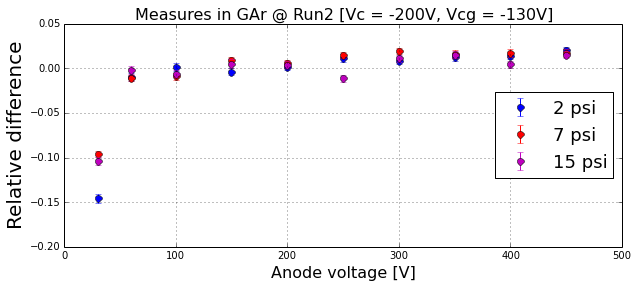

In [25]:
fig = plt.figure(figsize=(10,4))
measure1=[1]
#run1_a=Ta_avg_v
#run1_c=Tc_avg_v
#run1_rms=Tc_rms_v
# gas run2:
anode_voltages=[30,60,100,150,200,250,300,350,400,450]
# liquid run2:
#anode_voltages=[46,75,100,150,200,250,300,350,400,450,500,600,700,800,900,1000]#RUN2

#cathode_voltages=[62.5,83,103,123,143,200,250,300,350,400,450,500,600,700]
#anode_voltagesRUN1=[13,18,23,34,44,54,103,150,200,300,400,491,600,700,800,900,1000]#RUN1
#run3, gas
#anode_voltages=[5, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 69, 80, 90, 100, 120, 141, 161, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]
#plt.plot_date(date_v,np.abs(Qa_avg_v))
#plt.plot_date(date_v,np.abs(Qc_avg_v))

Qa_avg_v=np.array(Qa_avg_v)
Qc_avg_v=np.array(Qc_avg_v)
Qa_rms_v=np.array(Qa_rms_v)
Qc_rms_v=np.array(Qc_rms_v)

ratio15=(np.array(np.abs(Qa_avgwf_v))-np.array(np.abs(Qc_avgwf_v)))/np.array(np.abs(Qc_avgwf_v))
err_ratio15=np.sqrt((np.array(Qa_rms_v)/(np.array(Qc_avgwf_v)))**2+(np.array(Qa_avgwf_v)*np.array(Qc_rms_v)/(np.array(Qc_avgwf_v))**2)**2)


#ratio=(Qa_avg_v)/(Qc_avg_v)
#print(ratio)
#err_ratio=np.sqrt((Qa_rms_v/Qc_avg_v)**2+(Qc_rms_v*Qa_avg_v/(Qc_avg_v)**2)**2)
#print(err_ratio)
#print(err_ratio)
#plt.errorbar(anode_voltages,Ta_avg_v,yerr=Ta_rms_v,fmt='o',color='r',label='Anode',markersize=6)
#plt.errorbar(anode_voltages,Tc_avg_v,yerr=Tc_rms_v,fmt='o',color='b',label='Cathode',markersize=6)

#plt.errorbar(anode_voltages,np.abs(Qa_avg_v),yerr=Qa_rms_v,fmt='o',color='r',label='Anode')
#plt.errorbar(anode_voltages,np.abs(Qc_avg_v),yerr=Qc_rms_v,fmt='o',color='b',label='Cathode')

#plt.errorbar(anode_voltages,np.abs(Qa_avgwf_v),yerr=Qa_rms_v,fmt='o',color='r',label='Anode',markersize=6)
#plt.errorbar(anode_voltages,np.abs(Qc_avgwf_v),yerr=Qc_rms_v,fmt='o',color='b',label='Cathode',markersize=6)
plt.errorbar(anode_voltages,ratio2,yerr=err_ratio2,fmt='o',color='b',label='2 psi',markersize=7)
plt.errorbar(anode_voltages,ratio7,yerr=err_ratio7,fmt='o',color='r',label='7 psi',markersize=7)
plt.errorbar(anode_voltages,ratio15,yerr=err_ratio15,fmt='o',color='m',label='15 psi',markersize=7)

plt.plot()
#plt.errorbar(anode_voltages,np.abs(ratio),yerr=err_ratio,fmt='o',color='g')
#plt.xlim([7.2e5,7.4e5])

#plt.ylim([17,23])
plt.grid()
plt.legend(numpoints=1,fontsize=18, loc=5)
plt.xlabel('Anode voltage [V]',fontsize=16)
#plt.ylabel('Amplitude [mV] [50-run avg.]',fontsize=16)
#plt.ylabel('Drift time [ms] [50-run avg.]',fontsize=16)
#plt.ylabel('Amplitude anode / amplitude cathode',fontsize=20)
plt.ylabel('Relative difference',fontsize=20)
plt.title('Measures in GAr @ Run2 [Vc = -200V, Vcg = -130V]',fontsize=16)
#plt.title('Measures in LAr @ Run1, [Vc = -200V, Vcg = -130V]',fontsize=16)
#plt.title('Drift time in LAr, [Vc = -200V, Vcg = -130V]',fontsize=16)

#fig.savefig('measures_LAr_VC100_VCG65.png')
plt.xlim([0,500])
#plt.ylim([0.00,0.16])
#plt.yscale('log')
plt.show()

In [ ]:
time_spread=[
Q_spread=[
corr_spread=[

    
xaxis=np.arange(49)

fig1 = plt.figure(figsize=(10,4))
plt.hist(time_spread)
plt.show()

fig2=plt.figure(figsize=(10,4))
plt.hist(Q_spread)
plt.show()
fig3=plt.figure(figsize=(10,4))
plt.plot(xaxis,np.array(time_spread)*100, 'ro')
plt.show()
fig4=plt.figure(figsize=(10,4))
plt.plot(xaxis,corr_spread,'bo')
plt.show()
print(np.std(Q_spread))

In [ ]:
time_not_spread=[
Q_not_spread=[
corr_not_spread=[
fig1 = plt.figure(figsize=(10,4))
plt.hist(time_not_spread)
plt.show()

fig2=plt.figure(figsize=(10,4))
plt.hist(Q_not_spread)
plt.show()

print(np.std(Q_not_spread))

In [ ]:
with_true=[0.21230869078843367, 0.21175369673439307, 0.2167943815861948, 0.19837422214729628, 0.2244023167175262, 0.21850639932633653, 0.20916557331171459, 0.25559746498371494, 0.21556739907739875, 0.28001047571439691]
with_false=[0.20479238311240588, 0.20078853286253082, 0.20739705411045012, 0.19163558137257247, 0.21567821153720304, 0.21070725037103841, 0.20563446678508754, 0.2472167259410144, 0.21025391722050574, 0.26890268681021917]
xaxis=np.arange(len(with_true))
fig4=plt.figure(figsize=(10,4))
plt.plot(xaxis,with_true,'bo')
plt.plot(xaxis,with_false,'ro')
plt.show()